# Tarea:

* Agrupar por sector (limpiar los datos)
* Entrenar una regresión Logística y encontrar los mejores hiperparámetros
* Probar cross-validation
* Graficar Precision-Recall curve

In [1]:
#Se importan todas las librerías necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import difflib
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve



In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (15, 4)

In [3]:
#Se lee el archivo del IPC Histórico y se parsea en un Pandas Dataframe
ipc_path = "ipc.xlsx"
market = pd.read_excel(ipc_path, index_col=0)
market.columns = [c.replace(" MF Equity", "").replace(" INDEX", "").replace("*", "") for c in market.columns]
market = market.drop('MEXBOL',axis = 1)

market.head()



,KIMBERA,GAPB,CEMEXCPO,ASURB,GFNORTEO,KOFUBL,AC,LABB,FEMSAUBD,OMAB,...,ALPEKA,MEGACPO,GCC,BIMBOA,GMEXICOB,GCARSOA1,TLEVICPO,ALFAA,BSMXB,PINFRA
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,40.37,152.05,8.72,243.89,94.99,123.90,104.68,13.85,161.63,83.61,...,24.19,64.19,44.81,45.95,36.79,70.98,94.34,34.10,30.25,202.73
2016-01-04,39.16,148.57,8.43,238.29,91.79,120.29,102.09,14.41,157.62,81.77,...,23.86,64.45,43.51,45.02,35.71,69.83,92.62,33.74,29.46,202.93
2016-01-05,38.89,147.93,8.31,233.03,91.72,118.82,101.12,13.77,157.80,81.58,...,23.52,63.16,43.51,45.77,36.45,70.70,91.89,33.99,29.72,203.56
2016-01-06,39.13,146.99,8.29,231.97,91.63,120.32,102.50,13.65,156.37,82.03,...,22.52,63.27,43.51,45.97,35.57,70.47,90.41,33.65,29.67,199.80
2016-01-07,39.16,141.32,7.64,230.71,89.54,120.20,101.16,13.25,155.14,80.94,...,22.26,62.78,42.76,46.18,35.01,68.15,90.23,31.46,28.50,196.75


In [4]:
#Se lee el archivo que contiene el diccionario de las empresas y sus datos.
index_path = "../Files/modulo3/bmv_emisoras.csv"
sector = pd.read_csv(index_path, index_col=0)



In [5]:
# Se genera un diccionario para realizar el cruce entre llos dos archivos y poder unir
sectores = dict()
for i in range(0,len(market.columns)):
    test = difflib.get_close_matches(market.columns[i][:-1], sector.index, n=1, cutoff=0.65)[0]
    sectores.update({market.columns[i]:{ 'Empresa':test, 'Sector':sector.loc[test].Sector}})
sectores

{'KIMBERA': {'Empresa': 'KIMBER', 'Sector': 'PRODUCTOS DE CONSUMO FRECUENTE'},
 'GAPB': {'Empresa': 'GAP', 'Sector': 'INDUSTRIAL'},
 'CEMEXCPO': {'Empresa': 'CEMEX', 'Sector': 'MATERIALES'},
 'ASURB': {'Empresa': 'ASUR', 'Sector': 'INDUSTRIAL'},
 'GFNORTEO': {'Empresa': 'GFNORTE', 'Sector': 'SERVICIOS FINANCIEROS'},
 'KOFUBL': {'Empresa': 'KOF', 'Sector': 'PRODUCTOS DE CONSUMO FRECUENTE'},
 'AC': {'Empresa': 'AC', 'Sector': 'PRODUCTOS DE CONSUMO FRECUENTE'},
 'LABB': {'Empresa': 'LAB', 'Sector': 'SALUD'},
 'FEMSAUBD': {'Empresa': 'FEMSA', 'Sector': 'PRODUCTOS DE CONSUMO FRECUENTE'},
 'OMAB': {'Empresa': 'OMA', 'Sector': 'INDUSTRIAL'},
 'GFINBURO': {'Empresa': 'GFINBUR', 'Sector': 'SERVICIOS FINANCIEROS'},
 'AMXL': {'Empresa': 'AMX', 'Sector': 'SERVICIOS DE TELECOMUNICACIONES'},
 'ALSEA': {'Empresa': 'ALSEA',
  'Sector': 'SERVICIOS Y BIENES DE CONSUMO NO BÁSICO'},
 'ORBIA': {'Empresa': 'ORBIA', 'Sector': 'INDUSTRIAL'},
 'PE&OLES': {'Empresa': 'PE&OLES', 'Sector': 'MATERIALES'},
 'GRUMAB

In [6]:
# Se adiciona el Sector a la tabla de IPC
pdSectores = pd.DataFrame(sectores)
pdSectores = pdSectores.T
market_T = market.T
pd_sectorizado = pd.merge(left = market_T, right = pdSectores, left_on = market_T.index, right_on = pdSectores.index)
pd_sectorizado.set_index(['Sector','key_0'], inplace = True)
pd_sectorizado.head()


,,2016-01-01 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,...,2019-12-24 00:00:00,2019-12-25 00:00:00,2019-12-26 00:00:00,2019-12-27 00:00:00,2019-12-30 00:00:00,2019-12-31 00:00:00,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,Empresa
Sector,key_0,,,,,,,,,,,,,,,,,,,,,
PRODUCTOS DE CONSUMO FRECUENTE,KIMBERA,40.37,39.16,38.89,39.13,39.16,38.65,37.85,39.08,39.95,39.54,...,38.83,38.83,39.02,38.77,38.50,37.50,37.50,38.09,38.07,KIMBER
INDUSTRIAL,GAPB,152.05,148.57,147.93,146.99,141.32,143.74,144.94,144.16,146.70,145.85,...,226.99,226.99,227.65,226.86,225.87,224.67,224.67,227.63,228.84,GAP
MATERIALES,CEMEXCPO,8.72,8.43,8.31,8.29,7.64,7.18,7.24,7.39,7.14,7.36,...,7.23,7.23,7.33,7.23,7.16,7.08,7.08,7.16,7.19,CEMEX
INDUSTRIAL,ASURB,243.89,238.29,233.03,231.97,230.71,229.76,227.83,231.81,226.71,225.29,...,353.16,353.16,357.94,356.15,354.06,354.04,354.04,360.48,362.25,ASUR
SERVICIOS FINANCIEROS,GFNORTEO,94.99,91.79,91.72,91.63,89.54,88.85,89.30,89.34,88.62,87.59,...,110.20,110.20,109.63,108.92,105.00,105.65,105.65,109.66,109.96,GFNORTE


In [7]:
# Se agrupan sacando la media de los índices por sector 
pd_sectorizado = pd_sectorizado.groupby(level = 'Sector').mean()
pd_sectorizado = pd_sectorizado.T
pd_sectorizado.head()

Sector,ENERGÍA,INDUSTRIAL,MATERIALES,PRODUCTOS DE CONSUMO FRECUENTE,SALUD,SERVICIOS DE TELECOMUNICACIONES,SERVICIOS FINANCIEROS,SERVICIOS Y BIENES DE CONSUMO NO BÁSICO
2016-01-01 00:00:00,72.34,117.845714,58.346,108.824286,13.85,56.883333,50.148333,216.333333
2016-01-04 00:00:00,72.98,116.128571,57.482,106.207143,14.41,56.366667,49.115000,212.393333
2016-01-05 00:00:00,71.48,115.488571,57.648,105.451429,13.77,55.673333,48.971667,209.043333
2016-01-06 00:00:00,70.94,114.577143,56.514,107.150000,13.65,55.140000,48.645000,202.943333
2016-01-07 00:00:00,72.31,112.128571,56.122,106.498571,13.25,54.783333,47.453333,200.226667


In [8]:
# Se adiciona una columna con los promedios por día.
pd_sectorizado['Media'] = pd_sectorizado.mean(axis = 1)
pd_sectorizado.index.rename('DATE', inplace = True) 
pd_sectorizado.head()


Sector,ENERGÍA,INDUSTRIAL,MATERIALES,PRODUCTOS DE CONSUMO FRECUENTE,SALUD,SERVICIOS DE TELECOMUNICACIONES,SERVICIOS FINANCIEROS,SERVICIOS Y BIENES DE CONSUMO NO BÁSICO,Media
DATE,,,,,,,,,
2016-01-01 00:00:00,72.34,117.845714,58.346,108.824286,13.85,56.883333,50.148333,216.333333,86.821375
2016-01-04 00:00:00,72.98,116.128571,57.482,106.207143,14.41,56.366667,49.115000,212.393333,85.635339
2016-01-05 00:00:00,71.48,115.488571,57.648,105.451429,13.77,55.673333,48.971667,209.043333,84.690792
2016-01-06 00:00:00,70.94,114.577143,56.514,107.150000,13.65,55.140000,48.645000,202.943333,83.694935
2016-01-07 00:00:00,72.31,112.128571,56.122,106.498571,13.25,54.783333,47.453333,200.226667,82.846560


In [9]:
# Se limpia la limpia la información información
y = (pd_sectorizado["Media"].pct_change() > 0).astype(int)
y.name = "target"
X = pd_sectorizado[["Media"]].pct_change().dropna()
X = X.join(y.shift(-1).dropna(), how="inner")
y = X["target"]
X = X[["Media"]]

In [10]:
# Se defdinen los periodos del entrenamiento y la prueba
train_period = "2019-10"
test_period = "2019-11-20"
Xtrain, ytrain = X[:train_period], y[:train_period]
Xtest, ytest = X[:test_period], y[:test_period]

In [11]:
# Se crea el Pipeline del modelo
pipe = Pipeline(steps=[("model", LogisticRegression())])

# Se determinan los parámetros a usar para el entrenamiento
C = np.logspace(0,100,100)
n_iter = np.random.randint(low=100, high=800, size=10)
params = {
    "model__solver": ['lbfgs'],
    "model__penalty": ['l2'],
    "model__fit_intercept": [True, False],
    "model__intercept_scaling": [True, False],
    "model__class_weight": ['balanced',None],
    "model__warm_start": [True, False],
    "model__multi_class":['auto'],
    "model__max_iter": n_iter,
    "model__C": C,

}

In [12]:
# Se determina el SearcCV con lo anteriormente definido
grid = GridSearchCV(estimator = pipe,
                    param_grid = dict(params),
                    cv = 5, n_jobs=8, return_train_score=True,iid = True)


In [13]:
# Se entrena el modelo
trained = grid.fit(Xtrain, ytrain)

In [14]:
# Se imprimen los mejores parámetros del entrenamiento
print("Lods mejores hiper parámetros son: C:",trained.best_params_['model__C'],", iteraciones máximas: ",trained.best_params_['model__max_iter'],", Penalty: ",trained.best_params_['model__penalty'])
trained.best_params_

Lods mejores hiper parámetros son: C: 1.0 , iteraciones máximas:  193 , Penalty:  l2


{'model__C': 1.0,
 'model__class_weight': 'balanced',
 'model__fit_intercept': False,
 'model__intercept_scaling': True,
 'model__max_iter': 193,
 'model__multi_class': 'auto',
 'model__penalty': 'l2',
 'model__solver': 'lbfgs',
 'model__warm_start': True}

In [15]:
# Se genera la matriz de confusión
yhat = trained.predict(Xtest)
confusion_matrix(ytest, yhat, labels=[0, 1])

array([[274, 231],
       [231, 277]], dtype=int64)

In [16]:
# se imprimen las métricas
precision_score(ytest, yhat)

0.5452755905511811

In [17]:
recall_score(ytest, yhat)

0.5452755905511811

In [18]:
f1_score(ytest, yhat)

0.5452755905511811

Text(0.5, 0, 'Nivel de proba asignada')

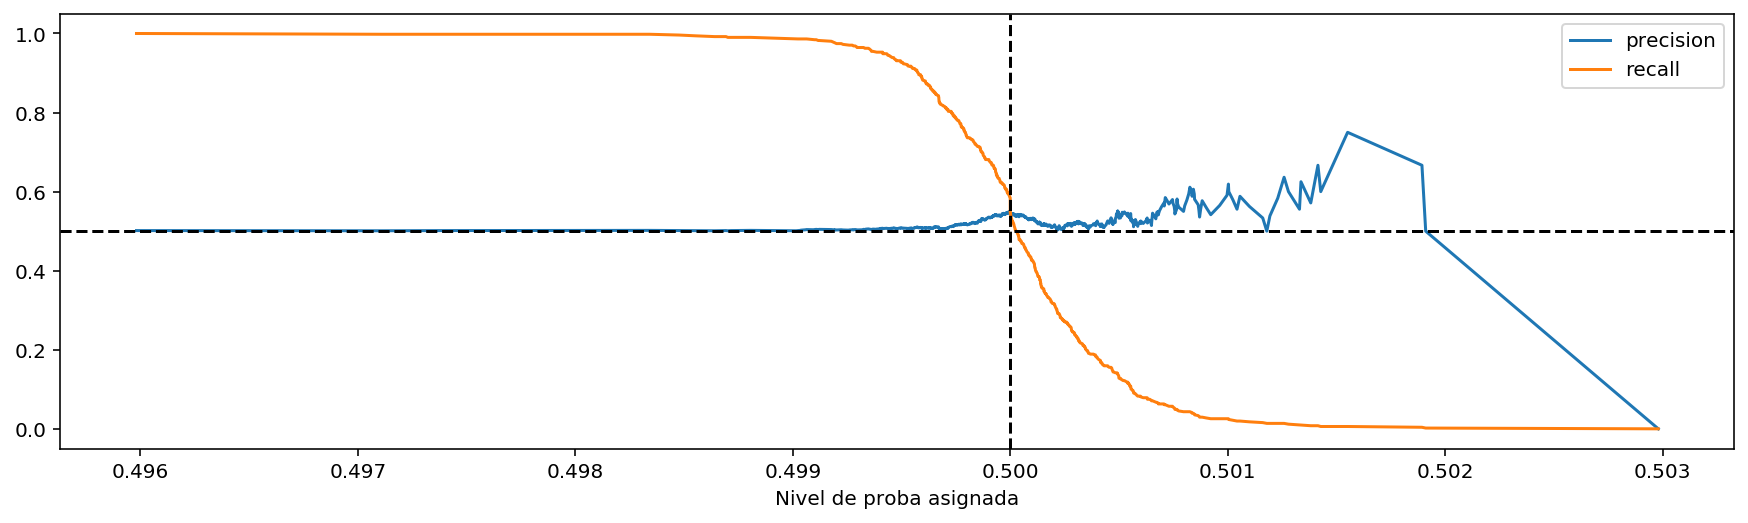

In [19]:
# Se grafica
proba_estimate = trained.predict_proba(Xtest)[:, 1]
prec, recall, threshold = precision_recall_curve(ytest, proba_estimate)

plt.plot(threshold, prec[:-1], label="precision")
plt.plot(threshold, recall[:-1], label="recall")
plt.legend()
plt.axvline(x=0.5, linestyle="--", c="black")
plt.axhline(y=0.5, linestyle="--", c="black")
plt.xlabel("Nivel de proba asignada")